In [1]:
import h5py
import numpy as np
from torch.utils.data import Dataset

class SudokuDataset(Dataset):
    def __init__(self, h5_file_path, transform=None):
        self.h5_file_path = h5_file_path
        self.transform = transform

        # Load the HDF5 data
        with h5py.File(h5_file_path, 'r') as f:
            self.images = np.array(f['images'])  # Shape: (N, 84, 84)
            self.labels = np.array(f['labels'])  # Shape: (N,)
        if len(self.images) > len(self.labels):
            print(f"Trimming images from {len(self.images)} to {len(self.labels)} to match labels.")
            self.images = self.images[:len(self.labels)]
        
        #print(f"Number of images: {len(self.images)}, Number of labels: {len(self.labels)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (84, 84)
        label = self.labels[idx]  # Label

        # Reshape and normalize the image
        image = image.reshape(1, 84, 84).astype(np.float32) / 255.0  # Shape: (1, 84, 84)

        return image, label


In [11]:
import torch
from torch.utils.data import DataLoader, Subset
from collections import Counter
from torchvision import transforms

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Dataset from separate files
train_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_training_set.h5'  # Update with your training file path
val_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_validation_images_20k.h5'  # Update with your validation file path
test_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_testing_set.h5'
# Assuming the dataset class can accept a file path
train_dataset = SudokuDataset(train_file_path, transform=transform)
val_dataset = SudokuDataset(val_file_path, transform=transform)
test_dataset = SudokuDataset(test_file_path, transform=transform)

# Step 1: Determine Class Distribution in Training Dataset
all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]  # Get all labels from the train set
class_counts = Counter(all_labels)  # Count samples per class
print("Class Distribution in Training Set:", class_counts)

# Step 2: Identify Minority Class Count
min_class_count = min(class_counts.values())

# Step 3: Balance the Training Dataset
balanced_train_indices = []
class_sample_counts = {cls: 0 for cls in class_counts.keys()}

# Balance only the training dataset
for idx, (data, label) in enumerate(train_dataset):
    if class_sample_counts[label] < min_class_count:
        balanced_train_indices.append(idx)
        class_sample_counts[label] += 1

# Create a balanced subset of the training dataset
balanced_train_dataset = Subset(train_dataset, balanced_train_indices)
print("Balanced Train Dataset Size:", len(balanced_train_dataset))

# Step 4: Create DataLoaders
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Output Dataset Information
print(f"Train Dataset Size: {len(balanced_train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Trimming images from 440000 to 435000 to match labels.
Class Distribution in Training Set: Counter({False: 250000, True: 185000})
Balanced Train Dataset Size: 370000
Train Dataset Size: 370000
Validation Dataset Size: 10000
Test Dataset Size: 30000


torch.Size([64])


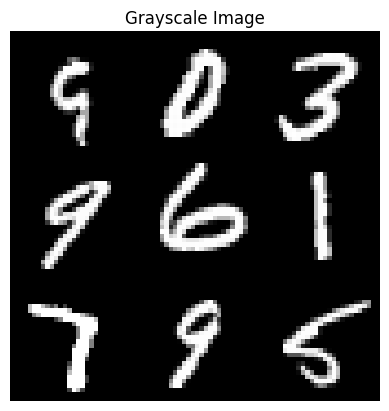

In [3]:
import torch
import matplotlib.pyplot as plt
for i in  train_loader:
    print(i[1].shape)
    image = i[0][0].squeeze(0)
    plt.imshow(image.numpy(), cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()
    break

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the CNN model with one additional convolutional layer
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 84, 84]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # [B, 16, 42, 42]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # [B, 32, 42, 42]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 32, 21, 21]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # [B, 64, 21, 21]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 64, 10, 10]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # [B, 128, 10, 10]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # [B, 128, 5, 5]
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                          # [B, 128 * 5 * 5]
            nn.Linear(128 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 1),                                     # Output: 1 value per input
            nn.Sigmoid()                                           # Probability of class 1
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

def validate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions

            # Metrics
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    return accuracy
#validate(model, val_loader)

# Training loop
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        validate(model, val_loader)
# Assuming train_loader is defined elsewhere
train(model, train_loader, criterion, optimizer, epochs)


Epoch 1/10, Loss: 3489.0836, Accuracy: 61.61%
Validation Accuracy: 64.03%
Epoch 2/10, Loss: 2926.2130, Accuracy: 71.29%
Validation Accuracy: 72.03%
Epoch 3/10, Loss: 2497.8402, Accuracy: 77.48%
Validation Accuracy: 76.39%
Epoch 4/10, Loss: 2162.1592, Accuracy: 81.71%
Validation Accuracy: 79.75%
Epoch 5/10, Loss: 1870.5696, Accuracy: 84.96%
Validation Accuracy: 82.69%
Epoch 6/10, Loss: 1648.5252, Accuracy: 87.32%
Validation Accuracy: 84.73%
Epoch 7/10, Loss: 1485.4664, Accuracy: 88.86%
Validation Accuracy: 85.51%
Epoch 8/10, Loss: 1349.2334, Accuracy: 90.08%
Validation Accuracy: 86.67%
Epoch 9/10, Loss: 1232.0068, Accuracy: 91.02%
Validation Accuracy: 86.23%
Epoch 10/10, Loss: 1132.6352, Accuracy: 91.86%
Validation Accuracy: 87.38%


In [9]:
train(model, train_loader, criterion, optimizer, epochs)


Epoch 1/10, Loss: 1035.2847, Accuracy: 92.64%
Validation Accuracy: 86.94%
Epoch 2/10, Loss: 939.7390, Accuracy: 93.38%
Validation Accuracy: 87.84%
Epoch 3/10, Loss: 858.8483, Accuracy: 93.99%
Validation Accuracy: 86.63%
Epoch 4/10, Loss: 783.0919, Accuracy: 94.53%
Validation Accuracy: 87.82%
Epoch 5/10, Loss: 710.4970, Accuracy: 95.06%
Validation Accuracy: 87.85%
Epoch 6/10, Loss: 644.7842, Accuracy: 95.56%
Validation Accuracy: 87.22%
Epoch 7/10, Loss: 587.9784, Accuracy: 95.94%
Validation Accuracy: 86.54%
Epoch 8/10, Loss: 532.9042, Accuracy: 96.37%
Validation Accuracy: 87.35%
Epoch 9/10, Loss: 491.0299, Accuracy: 96.65%
Validation Accuracy: 87.69%
Epoch 10/10, Loss: 450.3299, Accuracy: 96.94%
Validation Accuracy: 86.65%


In [ ]:
train(model, train_loader, criterion, optimizer, epochs)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import precision_score, recall_score, f1_score

def test(model, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.long().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions

            # Collect all predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Per-class accuracy
    per_class_accuracy = []
    for cls in range(num_classes):
        class_indices = (all_labels == cls)
        class_correct = (all_preds[class_indices] == all_labels[class_indices]).sum()
        class_total = class_indices.sum()
        per_class_acc = 100 * class_correct / class_total if class_total > 0 else 0
        per_class_accuracy.append(per_class_acc)

    print(f"Test Metrics:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("  Per-Class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"    Class {i}: {acc:.2f}%")

    return accuracy, precision, recall, f1, per_class_accuracy

    
test(model, test_loader, 2)

Test Metrics:
  Accuracy: 87.00%
  Precision: 0.8945
  Recall:    0.8389
  F1 Score:  0.8658
  Per-Class Accuracy:
    Class 0: 90.11%
    Class 1: 83.89%


(86.99666666666667,
 0.8945048695528542,
 0.8388666666666666,
 0.8657928234767951,
 [90.10666666666667, 83.88666666666667])

In [16]:
save_path = 'model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to model.pth
